In [1]:
from ultralytics import SAM, YOLO
import cv2
import numpy as np
import torch
import os 
# Load a model
model = SAM('sam_l.pt')

In [2]:
def get_bounding_box(mask):
    # Convert tensor to numpy array if it's a PyTorch tensor
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    print(mask.shape)
    # Get the dimensions of the mask
    _ , height, width = mask.shape
    
    # Initialize extreme points of the bounding box
    min_x, min_y = width, height
    max_x, max_y = 0, 0
    
    # Iterate through each pixel in the mask
    for y in range(height):
        for x in range(width):
            if mask[0, y, x] == True:  # Assuming True indicates the object in the mask
                # Update extreme points of the bounding box
                min_x = min(min_x, x)
                min_y = min(min_y, y)
                max_x = max(max_x, x)
                max_y = max(max_y, y)
    
    # If no True pixels found, return None
    if min_x == width or min_y == height or max_x == 0 or max_y == 0:
        print("No 'True' pixels found in the mask.")
        return None
    
    # Compute width and height of the bounding box
    width_bb = max_x - min_x + 1
    height_bb = max_y - min_y + 1
    
    return min_x, min_y, width_bb, height_bb

In [3]:
def crop_image(image_path, min_x, min_y, max_x, max_y, save_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Crop the image using the bounding box coordinates
    cropped_image = image[min_y:max_y, min_x:max_x]
    cv2.imwrite(save_path, cropped_image)

In [4]:
def bbox_to_percent(bbox, img_shape):
    print(img_shape)
    h, w,_ = img_shape
    min_x, min_y, width_bb, height_bb = bbox 
    
    norm_x = min_x/w
    norm_y = min_y/h
    norm_w = width_bb/w
    norm_h=height_bb/h
    return norm_x, norm_y, norm_w, norm_h

In [5]:
def crop_img_and_labels(img_path, label_path,output_folder_label, output_folder_img):
    print(label_path)
    image_filename = os.path.basename(img_path) 
    image = cv2.imread(img_path)
    label = open(label_path, "r").read()
    labels = label.split("\n")[:-1]
    sub_label_filename = f"{os.path.splitext(image_filename)[0]}.txt"
    sub_label_path = os.path.join(output_folder_label, sub_label_filename)
    
    result = model(img_path,points=[1100,1400])
    bbox_road = get_bounding_box(result[0].masks.data)
    min_x, min_y, width, height = bbox_road
    norm_x, norm_y, norm_w, norm_h = bbox_to_percent(bbox_road,image.shape)
    filename = f"{output_folder_img}/{image_filename}"
    crop_image(img_path,min_x, min_y, min_x+width, min_y+height, filename)
    with open(sub_label_path,"w") as file:
        for l in labels:
            class_id, x_center, y_center, box_width, box_height = map(float, l.split())
            x_left = x_center-(box_width/2)
            x_center, y_center, box_width, box_height = (
                        (x_center-norm_x) / norm_w,
                        (y_center - norm_y) / (norm_h),
                        box_width / norm_w,
                        (box_height) / norm_h,
                    )
            bb = x_center, y_center, box_width, box_height
            file.write(str(int(class_id)) + " " + " ".join([str(a) for a in bb]) + '\n')
        file.close()

In [6]:
def getImagesInDir(dir_path: str):
    image_list = []
    for root, dirs, files in os.walk(os.path.join(dir_path, 'images')):
        for filename in files:
            if filename.lower().endswith('.jpg'):
                image_list.append(os.path.join(root, filename))

    return image_list


In [10]:
output_folder_img= "cropped_dataset/images"
output_folder_label ="cropped_dataset/labels"

def create_dataset(path):
    imgs = getImagesInDir(path)
    for img in imgs:
        basename = os.path.basename(img)
        basename_no_ext = os.path.splitext(basename)[0]
        label_path = f'{path}/labels/{basename_no_ext}.txt'
        crop_img_and_labels(img, label_path=label_path, output_folder_label=output_folder_label, output_folder_img= output_folder_img)

create_dataset('dataset/train')
create_dataset('dataset/validate')


dataset/train/labels/Norway_000501.txt

image 1/1 c:\Users\idi40\Desktop\data\RDD\AutoAnnotation\dataset\train\images\Norway_000501.jpg: 1024x1024 150.0ms
Speed: 4.0ms preprocess, 150.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)
(1, 2035, 4040)
(2035, 4040, 3)
dataset/train/labels/Norway_000502.txt

image 1/1 c:\Users\idi40\Desktop\data\RDD\AutoAnnotation\dataset\train\images\Norway_000502.jpg: 1024x1024 445.0ms
Speed: 5.0ms preprocess, 445.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)
(1, 2035, 4040)
(2035, 4040, 3)
dataset/train/labels/Norway_000503.txt

image 1/1 c:\Users\idi40\Desktop\data\RDD\AutoAnnotation\dataset\train\images\Norway_000503.jpg: 1024x1024 294.0ms
Speed: 4.0ms preprocess, 294.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)
(1, 2041, 3643)
(2041, 3643, 3)
dataset/train/labels/Norway_000504.txt

image 1/1 c:\Users\idi40\Desktop\data\RDD\AutoAnnotation\dataset\train\images\Norway_000504.jpg: 10

Traceback (most recent call last):
  File "c:\Users\idi40\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\idi40\AppData\Local\Temp\ipykernel_26400\3988152977.py", line 12, in <module>
    create_dataset('dataset/train')
  File "C:\Users\idi40\AppData\Local\Temp\ipykernel_26400\3988152977.py", line 10, in create_dataset
    crop_img_and_labels(img, label_path=label_path, output_folder_label=output_folder_label, output_folder_img= output_folder_img)
  File "C:\Users\idi40\AppData\Local\Temp\ipykernel_26400\2772119981.py", line 11, in crop_img_and_labels
    bbox_road = get_bounding_box(result[0].masks.data)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\idi40\AppData\Local\Temp\ipykernel_26400\1363513558.py", line -1, in get_bounding_box
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last

In [ ]:
def draw_yolo_data(image, labels_path):
        
        img_height, img_width, _  = image.shape
        print(img_height, img_width)
        label = open(labels_path, "r").read()
        label = label.split("\n")[:-1]
        for l in label:
                class_id, x_center, y_center, box_width, box_height = map(float, l.split())
                x_center, y_center, box_width, box_height = (
                        x_center * img_width,
                        y_center * img_height,
                        box_width * img_width,
                        box_height * img_height
                        )
                x1 = int((x_center - box_width // 2))
                y1 = int((y_center - box_height // 2))
                x2 = int((x_center + box_width // 2))
                y2 = int((y_center + box_height // 2))
                print(img_height, img_width)
                print(f'{x1},{x2},{y1},{y2}, {box_height}, {box_width}')

                # Draw the rectangle on the image
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.imshow("Image with Bounding Boxes", cv2.resize(image, (2040,1040)))
        cv2.waitKey(0)
        cv2.destroyAllWindows()

test_path = "cropped_dataset/labels/Norway_000005.txt"
IMG_PATH = "cropped_dataset/images/Norway_000005.jpg"
img = cv2.imread(IMG_PATH)
draw_yolo_data(img,test_path)




1009 2486
1009 2486
1139,1279,129,163, 35.17000000000007, 140.07999999999993
1009 2486
155,775,566,998, 432.49, 621.43
1009 2486
1189,1289,319,369, 51.63999999999987, 100.30999999999995
1009 2486
1285,1375,392,418, 27.809999999999942, 90.3800000000001
1009 2486
1471,1549,167,195, 29.819999999999936, 78.43000000000006
1009 2486
1767,1805,118,130, 12.419999999999844, 38.16000000000008
1009 2486
1755,1809,431,461, 30.779999999999973, 54.62000000000011
1009 2486
1779,1805,81,107, 26.480000000000015, 27.399999999999864
1009 2486
1648,1746,495,825, 331.5699999999999, 99.05999999999995
1009 2486
1215,1329,462,508, 46.33999999999992, 114.98000000000002
1009 2486
1345,1537,87,155, 69.66000000000008, 193.8800000000001
1009 2486
10,152,787,881, 94.38999999999986, 142.62
1009 2486
1582,1636,103,133, 30.350000000000133, 54.559999999999945


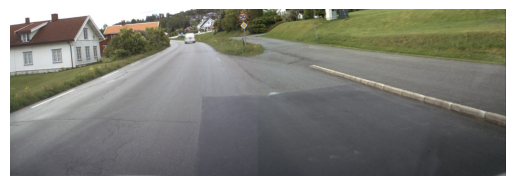

In [ ]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
yolo =  YOLO("../runs/detect/train31/weights/best.pt")
result = yolo.predict(cropped_image, save=True)


0: 416x1408 5 D00s, 1 D20, 1 D40, 69.0ms
Speed: 7.9ms preprocess, 69.0ms inference, 14.0ms postprocess per image at shape (1, 3, 416, 1408)
Results saved to runs\detect\predict3
